In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from lsst.sims.utils import hpid2RaDec, galacticFromEquatorial
import healpy as hp
import pandas as pd

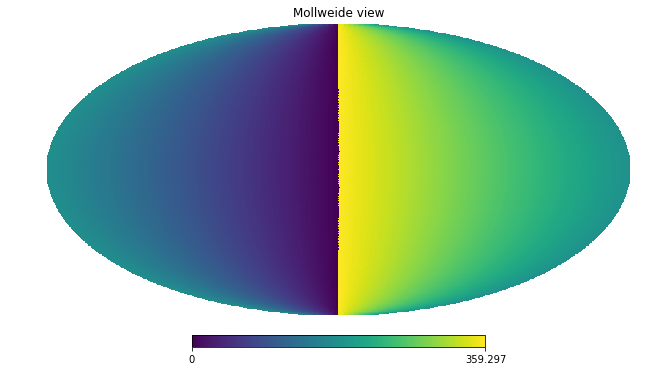

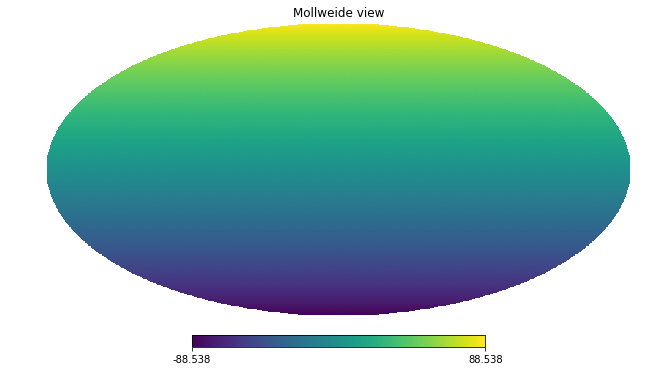

In [2]:
# Set up RA, dec maps
nside = 64
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
hp.mollview(ra)
hp.mollview(dec)

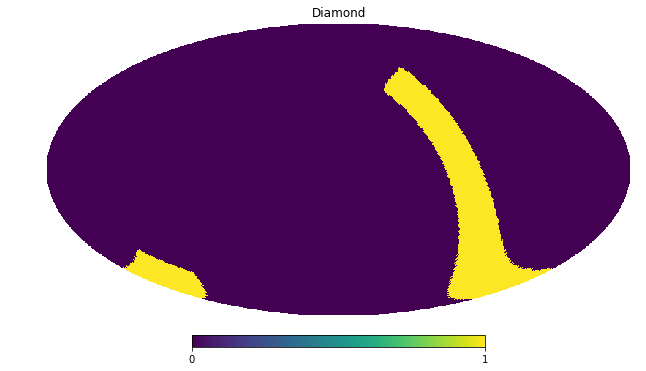

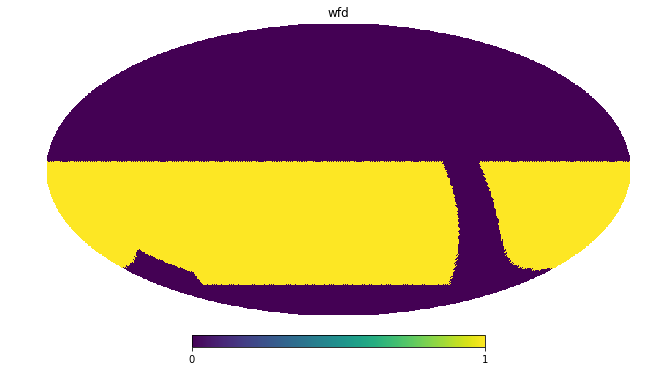

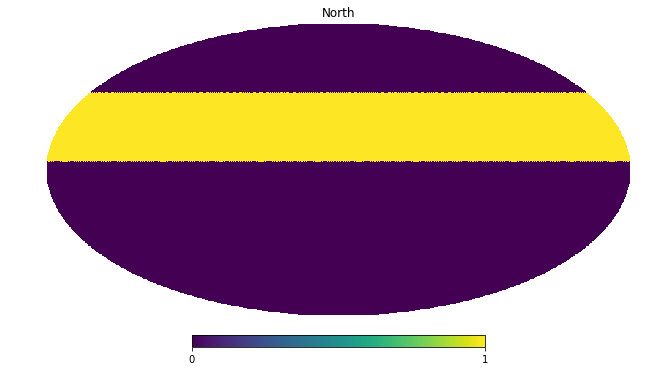

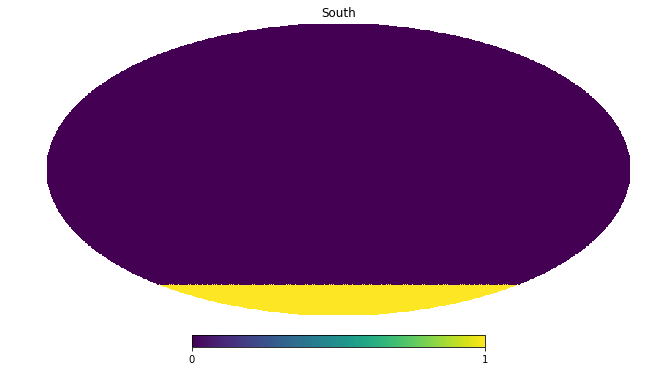

In [3]:
# Let's define some regions!
g_long, g_lat = galacticFromEquatorial(ra, dec)

diamond = np.where(((g_long < 90) | (g_long > 270)) & (np.abs(g_lat) < 10))
diamond_map = np.zeros(hp.nside2npix(nside), dtype=float)
diamond_map[diamond] = 1
wfd = np.where((dec > -62.5) & (dec < 3.6))
wfd_map = np.zeros(hp.nside2npix(nside), dtype=float)
wfd_map[wfd] = 1
wfd_map[diamond] = 0
hp.mollview(diamond_map, title='Diamond')
hp.mollview(wfd_map, title='wfd')

north = np.where((dec < 40) & (dec > -20))
north_map = np.zeros(hp.nside2npix(nside), dtype=float)
north_map[north] = 1
north_map[wfd] = 0
hp.mollview(north_map, title='North')

south = np.where(dec < -62)
south_map = np.zeros(hp.nside2npix(nside), dtype=float)
south_map[south] = 1
south_map[wfd] = 0
hp.mollview(south_map, title='South')

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


billions of stars
   rmag   diamond       wfd     north     south       sum
0  27.6  6.465681  1.490426  1.008364  0.432497  9.396969
1  27.4  6.140197  1.440990  0.967790  0.416190  8.965167
2  27.0  5.511432  1.340335  0.887905  0.383726  8.123398
3  24.6  2.692155  0.767473  0.482810  0.212733  4.155170
4  24.4  2.525433  0.728132  0.456084  0.201232  3.910881
5  24.0  2.216201  0.654899  0.406173  0.179699  3.456971
billions of stars
   zmag   diamond       wfd     north     south       sum
0  27.6  6.832198  1.564707  1.057991  0.454040  9.908936
1  27.4  6.827466  1.561767  1.056839  0.453399  9.899471
2  27.0  6.814310  1.553530  1.052984  0.451435  9.872258
3  24.6  5.753649  1.252742  0.889471  0.378159  8.274021
4  24.4  5.398339  1.190834  0.846554  0.359622  7.795349
5  24.0  4.682084  1.065393  0.754530  0.320813  6.822821


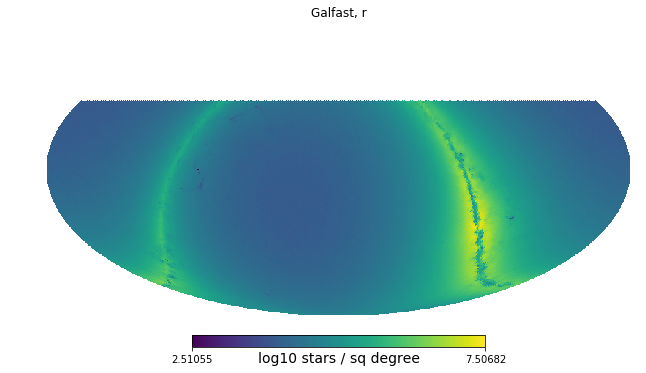

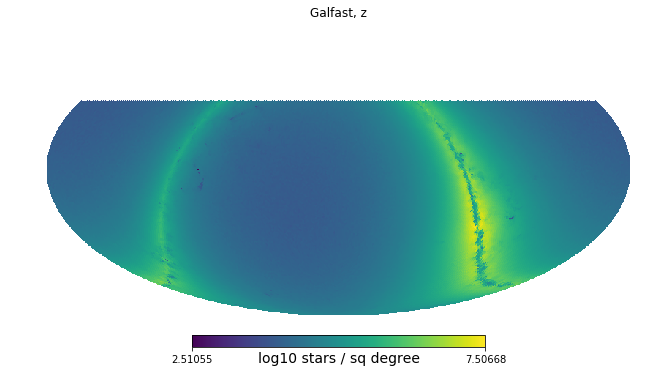

In [4]:
filtername = 'r'

for filtername in 'rz':

    # Let's load up the galfast map
    data = np.load('/Users/yoachim/git_repos/sims_maps/StarMaps/starDensity_%s_nside_64.npz' % filtername)
    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    starDensity = data['starDensity'].copy()
    # magnitude bins 
    bins=data['bins'].copy()
    # pixels where there were so many stars some were skipped
    mask = data['overMaxMask'].copy
    data.close()
    hp.mollview(np.log10(starDensity[:,-1]), title='Galfast, %s' % filtername, unit='log10 stars / sq degree')


    mags = [27.6, 27.4,  27., 24.6, 24.4,  24.]
    indxes = [np.where(np.round(bins[1:]*10) == np.round(rmag*10)) for rmag in mags]

    masks = {'diamond': diamond_map, 'wfd': wfd_map, 'north': north_map, 'south': south_map}
    pix_area = hp.nside2pixarea(nside, degrees=True)


    names = ['%smag' % filtername]
    names.extend(list(masks.keys()))
    types = [float]*len(names)
    result_array = np.zeros(len(mags), dtype=list(zip(names,types)))

    for i,indx in enumerate(indxes):
        for key in masks:
            result_array[i][key] = np.sum(masks[key]*starDensity[:,indx].ravel())*pix_area/1e9
        result_array[i]['%smag' % filtername] = bins[1:][indx]

    df = pd.DataFrame(result_array)
    df['sum'] = df['diamond'] + df['wfd'] + df['north'] + df['south']
    print('billions of stars')
    print(df)

In [5]:
# Check the faintest map


In [6]:
# Double check that we did indeed load up the correct resolution map
#hp.npix2nside(starDensity[:,-1].size) == nside

In [7]:
#bins

In [8]:
# rather than interpolate, let's just show what we got
